In [8]:
%matplotlib widget
%matplotlib widget

import os
import tf
import rospy
import numpy as np
import jupyros as jr
import ipywidgets as widgets
import matplotlib.pyplot as plt

from jupyros import ros3d
from std_msgs.msg import Int32
from std_msgs.msg import String
from nav_msgs.msg import Odometry
from IPython.display import display
from sensor_msgs.msg import LaserScan
from IPython.display import clear_output
from ipywidgets import interact, interactive
from geometry_msgs.msg import Twist, Vector3 
from matplotlib.animation import FuncAnimation
from final_assignment.srv import Coordinates
from tf.transformations import quaternion_matrix
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox

reached_points = []

In [9]:
def set_velocity(direction):
    
    init = Vector3(0, 0, 0)
    repost = Twist(init, init)
    
    # Direction control with buttons
    if direction == 'w':
        repost.linear.x = velocity.value
    
    elif direction == 's':
        repost.linear.x = -velocity.value
    
    elif direction == 'd':
        repost.angular.z = -velocity.value
    
    elif direction == 'a':
        repost.angular.z = velocity.value
    
    # Publish to /new_cmd_vel topic
    pub = rospy.Publisher('/new_cmd_vel', Twist, queue_size = 10)
    pub.publish(repost)

In [10]:
def driving_console():
    # Interface for control with keyboard
    display(driving_comm)
    display(check)
    display(bcanc)
    
    up.on_click(on_button_clicked_w)
    down.on_click(on_button_clicked_s)
    left.on_click(on_button_clicked_a)
    right.on_click(on_button_clicked_d)
   
    check.observe(check_handler, names = 'value')
    bcanc.on_click(on_button_clicked_canc)
    
    # Visualize map
    display_map()

In [11]:
def menu_choice(choice):
    #callback for events on the modality choice menu
    if choice == "mode1":
        display(coo_x, coo_y, bstart, bcanc)
        bstart.on_click(on_button_clicked_start)
        bcanc.on_click(on_button_clicked_canc)
    else:
        display(velocity)
        driving_console()

In [12]:
def display_map():
    # Visualize identical map of Gazebo to show robot's movement in real-time
    v = ros3d.Viewer()
    rc = ros3d.ROSConnection(url = "ws://localhost:9090")
    tf_client = ros3d.TFClient(ros = rc, fixed_frame = "map")

    laser_view = ros3d.LaserScan(topic = "/scan", ros = rc, tf_client = tf_client)
    map_view = ros3d.OccupancyGrid(topic = "/map", ros = rc, tf_client = tf_client, continuous = True)
    path = ros3d.Path(topic = "/move_base/NavfnROS/plan", ros = rc, tf_client = tf_client)
    urdf = ros3d.URDFModel(ros = rc, tf_client = tf_client, path = os.environ.get('JUPYROS_ASSETS_URL', "http://localhost:3000"))
    g = ros3d.GridModel()
    v.objects = [laser_view, map_view, urdf]
    display(v)

In [13]:
# Function to handle menu cases
def menu_handler(b):
    menu_choice(menu.value)

# Function to return to main menu
def on_button_clicked_canc(b):
    clear_output()

# Function /obstacle_avoidance checking
def check_handler(b):
    rospy.set_param("/obstacle_avoidance", check.value)
    
# Function to set a new position to move to  
def on_button_clicked_start(b):
    with output:
        rospy.wait_for_service('navigation')
        new_pose = rospy.ServiceProxy('navigation', Coordinates)
        rt = new_pose(coo_x.value, coo_y.value)
        if rt.return_ == 1:
            print("The robot has reached its goal!")
            reached_points.append("Reached!")
        else:
            print("Time is out!")
            reached_points.append("The robot has not reached its goal!")
        display(bcanc)
        bcanc.on_click(on_button_clicked_canc)
         
# Set velocity on clicked button
def on_button_clicked_w(b):
    set_velocity('w')
def on_button_clicked_s(b):
    set_velocity('s')
def on_button_clicked_a(b):
    set_velocity('a')
def on_button_clicked_d(b):
    set_velocity('d')


Textarea(value='Hello! Please select one of the modes below:')

RadioButtons(description='driving:', options=('mode1', 'mode2'), value=None)

Output()

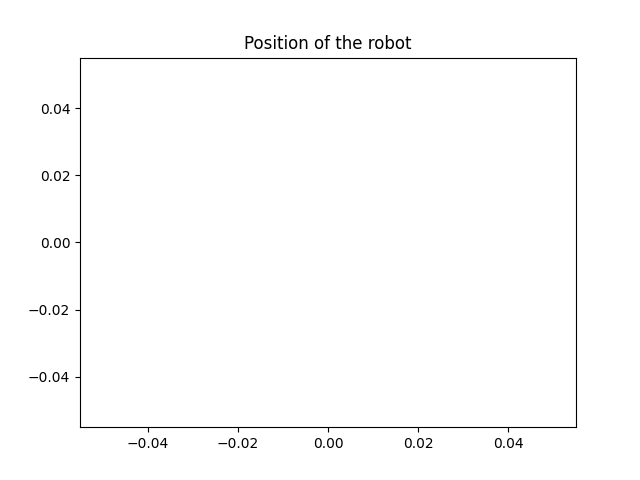

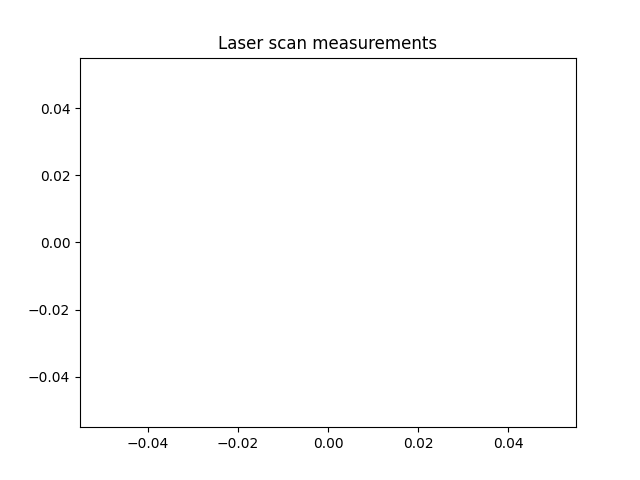

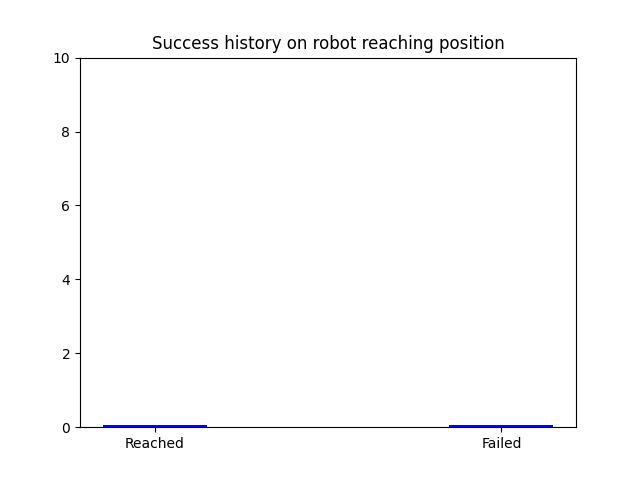

FloatText(value=0.0, description='X coordinate: ')

FloatText(value=0.0, description='Y coordinate: ')

Button(description='Start moving', style=ButtonStyle())

Button(description='Return to main menu', style=ButtonStyle())

In [14]:
class Visualiser:
    def __init__(self, limit_on_x, fig_title):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'bo')
        self.x_data, self.y_data = [], []
        self.x_limits = limit_on_x
        self.ax.set_title(fig_title)
        
    def plot_init(self):
        self.ax.set_xlim(-self.x_limits, self.x_limits)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_clbk(self, msg):
        self.y_data.append(msg.pose.pose.position.y) 
        self.x_data.append(msg.pose.pose.position.x)
       
    def laser_clbk(self, msg):
        self.x_data = msg.ranges
        self.y_data = msg.intensities        
   
    def refresh_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    
class Analysis:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.y_data = [0.05, 0.05] 
        self.labels = ['Reached', 'Failed'] 
        self.bar = self.ax.bar(self.labels, self.y_data, color = 'b', width = 0.3)
        self.ax.set_ylim(top = 10)
        self.ax.set_title('Success history on robot reaching position')
    
    def objective_clbk(self, msg):
        if msg.data == 1:
            self.y_data[0] += 1
        else :
            self.y_data[1] += 1
            
    def animate(self, frame):
        index = self.y_data[frame]
        self.bar[frame].set_height(index)


rospy.init_node('user_interface')

intro = widgets.Textarea(value = 'Hello! Please select one of the modes below:', disabled = False)

#create starting menu interface
menu = widgets.RadioButtons(options = ["mode1", "mode2"], value = None, description = 'driving:', disabled = False)
bstart = widgets.Button(description = "Start moving")
bcanc = widgets.Button(description = "Return to main menu")

#boxes for entering the coordinate of the taget to reach
coo_x = widgets.FloatText(description = "X coordinate: ")
coo_y = widgets.FloatText(description = "Y coordinate: ")

velocity = widgets.FloatSlider(min = 0, max = 3, step = 0.1, value = 1, description = 'Robot speed: ');

#listener for driving choice
menu.observe(menu_handler, names = 'value')

#console buttons
up = Button(description = 'UP', layout = Layout(grid_area = 'b1'))
left = Button(description = 'LEFT', layout = Layout(grid_area = 'b2'))
right = Button(description = 'RIGHT', layout = Layout( grid_area = 'b3'))
down = Button(description = 'DOWN', layout = Layout(grid_area = 'b4'))

HBox([VBox([right, down]),VBox([up, left])])

driving_comm = GridBox(children = [up, left, right, down],layout = Layout(
    width = '50%', 
    grid_template_rows = 'auto auto',
    grid_template_columns='33% 33% 33% 33%',
    grid_template_areas='''
    " . b1 . "
    "b2 . b3 "
    " . b4 . "
    ''')
)

#checkbox widget for activate/deactivate the collision avoidance option during the manual navigation of the robot
check = widgets.Checkbox(value = False, description = 'active collision avoidance')

#create an output cell
output = widgets.Output()

#display both button and output cell display main menu of the GUI
display(intro, menu, output)

vis_odom = Visualiser(10, 'Position of the robot')
sub_odom = rospy.Subscriber('/odom', Odometry, vis_odom.odom_clbk)
ani1 = FuncAnimation(vis_odom.fig, vis_odom.refresh_plot, init_func = vis_odom.plot_init)
plt.show(block = True)

vis_scan = Visualiser(100, 'Laser scan measurements')
sub_scan = rospy.Subscriber('/scan', LaserScan, vis_scan.laser_clbk)
ani2 = FuncAnimation(vis_scan.fig, vis_scan.refresh_plot, init_func = vis_scan.plot_init)
plt.show(block = True)

analysis= Analysis()
sub_success = rospy.Subscriber('/goal_reached', Int32, analysis.objective_clbk)
ani3 = FuncAnimation(analysis.fig, analysis.animate, frames=2)
plt.show(block = True)